# Philosopher Reasearch

## Sentiment Analysis

This code block is importing necessary Python libraries

In [1]:
# importing required libraries
import numpy as np 
import pandas as pd 
import os
from dotenv import load_dotenv
load_dotenv()
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from time import perf_counter
import re
from heapq import nlargest

Find the directory path of data

In [2]:
for dirname, _, filenames in os.walk(os.getenv('data_path')):
    for filename in filenames:
        main_path = os.path.join(dirname, filename)

Read in the csv data and save it to a dafa frame

In [3]:
df = pd.read_csv(main_path)
df.head()

,title,author,school,sentence_spacy,sentence_str,original_publication_date,corpus_edition_date,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
0,Plato - Complete Works,Plato,plato,"What's new, Socrates, to make you leave your ...","What's new, Socrates, to make you leave your ...",-350,1997,125,"what's new, socrates, to make you leave your ...","['what', 'new', 'socrates', 'to', 'make', 'you...","what be new , Socrates , to make -PRON- lea..."
1,Plato - Complete Works,Plato,plato,Surely you are not prosecuting anyone before t...,Surely you are not prosecuting anyone before t...,-350,1997,69,surely you are not prosecuting anyone before t...,"['surely', 'you', 'are', 'not', 'prosecuting',...",surely -PRON- be not prosecute anyone before ...
2,Plato - Complete Works,Plato,plato,The Athenians do not call this a prosecution b...,The Athenians do not call this a prosecution b...,-350,1997,74,the athenians do not call this a prosecution b...,"['the', 'athenians', 'do', 'not', 'call', 'thi...",the Athenians do not call this a prosecution ...
3,Plato - Complete Works,Plato,plato,What is this you say?,What is this you say?,-350,1997,21,what is this you say?,"['what', 'is', 'this', 'you', 'say']",what be this -PRON- say ?
4,Plato - Complete Works,Plato,plato,"Someone must have indicted you, for you are no...","Someone must have indicted you, for you are no...",-350,1997,101,"someone must have indicted you, for you are no...","['someone', 'must', 'have', 'indicted', 'you',...","someone must have indict -PRON- , for -PRON- ..."


In [4]:
stopwords = list(STOP_WORDS)
punctuation += '\n'

class DataSummarizer:

    # initialise variables
    def __init__(self, path = None, corpus = None):
        self.path = path
        self.corpus = corpus
        self.wordFrequencies = {}
        self.sentenceScore = {}
        self.numSentences = 0
        self.nlp = spacy.load('en_core_web_sm')
        self.doc = self.nlp(self.corpus)

    def printCorpus(self):
        print(self.corpus)

    def isWordInDict(self, word):
        if word not in self.wordFrequencies.keys():
            return False
        else:
            return True

    def calculateWordFrequency(self):
        for word in self.doc:
            lowerWord = word.text.lower()
            if self.isWordInDict(lowerWord):
                self.wordFrequencies[lowerWord] += 1
            else:
                self.wordFrequencies[lowerWord] = 1

    def maxFrequency(self):
        maxFreq = max(self.wordFrequencies.values())

        return maxFreq
    
    def normaliseWordFrequency(self):
        for word in self.wordFrequencies.keys():
            self.wordFrequencies[word] = self.wordFrequencies[word]/self.maxFrequency()

    def calculateSentenceScore(self):
        sentences = [sentence for sentence in self.doc.sents]
        self.numSentences = len(sentences)

        for sentence in sentences:
            for word in sentence:
                lowerWord = word.text.lower()
                if lowerWord in self.wordFrequencies.keys():
                    if sentence not in self.sentenceScore.keys():
                        self.sentenceScore[sentence] = self.wordFrequencies[lowerWord]
                    else:
                        self.sentenceScore[sentence] += self.wordFrequencies[lowerWord]

    def SummarizeMyText(self, fractionToReduce = 0.2):
        self.calculateWordFrequency()
        self.normaliseWordFrequency()
        self.calculateSentenceScore()
        
        reducedSentNum = int (self.numSentences * fractionToReduce)
        print ('Total number of Sentences = {}'.format(self.numSentences))
        print('Num of Sentences Reduced to {}'.format(reducedSentNum))
        
        # summaryList = nlargest(reducedSentNum, self.sentenceScore, key = self.sentenceScore.get)
        # for sentence in summaryList:
        #     print(sentence, end = '')

In [5]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

class DataAnalyzer:

    def createWordCloud(self, corpus, title):
        wordcloud = WordCloud(width = 800, height = 800, background_color = 'grey', stopwords = stopwords, min_font_size = 10).generate(corpus)

        plt.figure(figsize = (7, 7), facecolor = None)
        plt.imshow(wordcloud)
        plt.rcParams.update({'font.size': 20})
        plt.axis('off')
        plt.title('Word Cloud: ' + title)
        plt.tight_layout(pad = 0)
        plt.show()
    
    def sentimentOfText(self, text):
        sentimentAnalyzer = SentimentIntensityAnalyzer()
        sentimentDict = sentimentAnalyzer.polarity_scores(text)

        if sentimentDict['compound'] >= 0.05:
            return 'positive'
        elif sentimentDict['compound'] <= -0.05:
            return 'negative'
        else:
            return 'neutral'
        
    def calculateSentimentTotalsForColumn(self, dataframe, columnName):
        numberOfPositives = 0
        numberOfNegatives = 0
        numberOfNeutrals = 0
        
        for i in range(len(dataframe)):
            sentiment = (self.sentimentOfText(dataframe[columnName].iloc[i]))
            
            if sentiment == 'positive':
                    numberOfPositives += 1
            elif sentiment == 'negative':
                numberOfNegatives += 1
            else:
                numberOfNeutrals += 1

        return numberOfPositives, numberOfNegatives, numberOfNeutrals
        
    def combineColumnText(self, dataframe, columnName):
        totalText = ''
        for value in dataframe[columnName]:
            totalText += value
        
        return totalText

    def plotPieChart(self, values, values_lables, author):
        plt.figure(figsize = (7, 7))
        plt.pie(values, labels = values_lables, autopct = '%1f%%')
        plt.title(f'Sentiment Analysis for {author}')
        
    def cleanData(Self, data):
        return re.sub('[^a-zA-Z0-9]+', ' ', data)


    def displayAnalysis(self, dataframe, author):
        start = perf_counter()
        df = dataframe[dataframe['author'] == author]

        corpus = self.combineColumnText(dataframe, 'sentence_lowered')
        numberOfPositives, numberOfNegatives, numberOfNeutrals = self.calculateSentimentTotalsForColumn(df, 'sentence_lowered')

        values = [numberOfPositives, numberOfNegatives, numberOfNeutrals]
        values_lables = ['positives', 'negatives', 'neutrals']
        self.plotPieChart(values, values_lables, author)

        corpusCleaned = self.cleanData(corpus)
        self.createWordCloud(corpusCleaned, f'{author}')

        SummarizerClass = DataSummarizer(corpus = corpusCleaned[:1000000])
        SummarizerClass.SummarizeMyText(fractionToReduce = 0.002)

        print('Time taken: {}'.format(perf_counter() - start ))

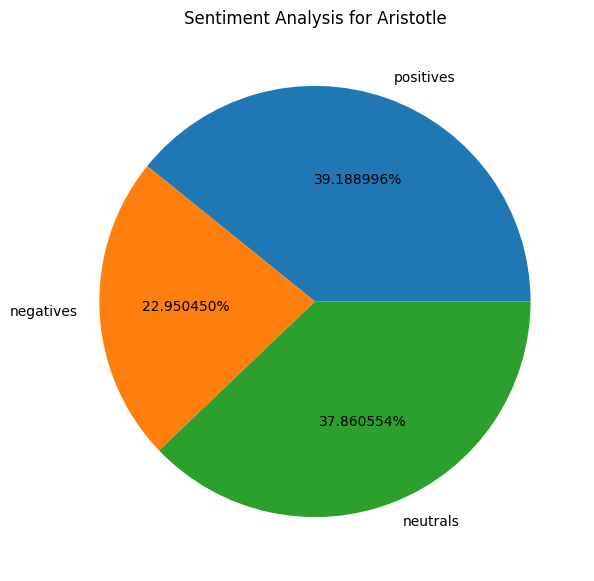

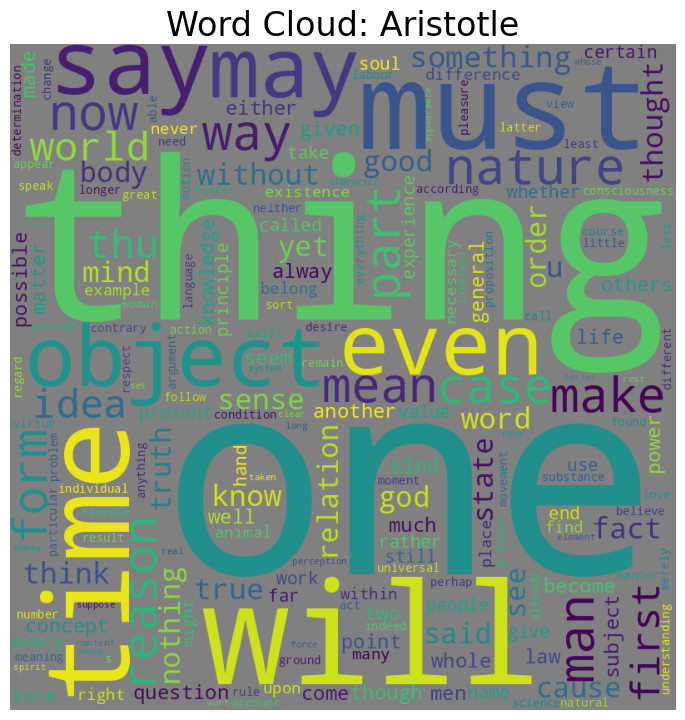

Total number of Sentences = 1092
Num of Sentences Reduced to 2
Time taken: 595.9304794740019


In [6]:
AnalyzerClass = DataAnalyzer()
AnalyzerClass.displayAnalysis(df, 'Aristotle')